In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, mean_squared_error, accuracy_score, f1_score, precision_score, recall_score, classification_report
from tensorflow import keras
from keras.models import Sequential
import matplotlib.pyplot as plt

In [2]:
ticker = 'High_Value_Dataset_July_2021_preprocessed'
input_dir = r'./data/'
file = os.path.join(input_dir, ticker + '.csv')

In [3]:
df = pd.read_csv(file, index_col=0)
df

,Gender,Race,Age,County,Current Facility,Offense Code,TDCJ Offense,TDCJ Number,Sentence (Years),Last Parole Decision,Parole Review Status,Parole Eligibility (Years),Sentence Left (Years)
2,1,6,85,55,92,11220000,1087,365547,999.0,0,0,18,999
3,1,2,84,173,71,9150000,7178,449674,999.0,0,0,15,999
5,1,1,83,204,9,11990003,1380,1241039,20.0,0,0,8,2
6,1,6,84,99,86,9130000,3487,248098,999.0,0,1,40,999
8,1,2,82,218,26,36120005,4952,1191104,20.0,0,0,16,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
118305,1,6,30,227,54,12990001,9666,2321078,10.0,0,0,0,9
118307,1,2,20,219,94,12990002,864,2302418,6.0,0,0,0,3
118310,1,1,29,55,82,12990001,9666,2343876,2.0,1,0,1,1
118313,1,1,24,214,20,35990003,8604,2321793,7.0,0,1,1,6


In [4]:
X = df.drop(['Last Parole Decision'], axis=1).values
Y = df['Last Parole Decision'].values

# np.random.shuffle(X)
# np.random.shuffle(Y)

assert X.shape[0] == Y.shape[0]

In [5]:
# X = pd.read_csv('./data/5_best_features.csv', index_col=0)
# Y = pd.read_csv('./data/target.csv', index_col=0)
# X = X.values
# Y = Y.values.ravel()

In [6]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=50)

## Helper Functions

In [10]:
def report(y_test, y_pred):
    """
    This function prints out the classification report for the given data.
    """
    TN, FP, FN, TP = confusion_matrix(y_test, y_pred, labels=[1, 0]).ravel()    ## TPR and TNR
    TPR = TP/(TP+FN) # Sensitivity, hit rate, recall, or test positive rate
    TNR = TN/(TN+FP) # Specificity or test negative rate
    print(f'\nTrue Positive Rate: {TPR:.2f} \nTrue Negative Rate: {TNR:.2f}')

    cm = confusion_matrix(y_test, y_pred)
    cmd = ConfusionMatrixDisplay(cm, display_labels=[0, 1])
    cmd.plot(include_values=True, cmap='viridis')

    print(f'Accuracy: {accuracy_score(y_test, y_pred):.2f}')
    print(f'Mean Squared Error: {mean_squared_error(y_test, y_pred):.2f}')
    print(f'F1 Score: {f1_score(y_test, y_pred):.2f}')

def validation(model, X, Y, k):
    """
    This function does k-fold validation on the given data.

    Parameters:
    model: The model to be used for validation.
    X: The data to be used for validation.
    Y: The labels to be used for validation.
    k: The number of folds to be used for validation.

    Returns:
    The average accuracy of the model using K Fold Validation.
    """
    acc = cross_val_score(model, X, Y, cv=k, scoring='accuracy')

    return print(f'\n10 Fold Validation accuracy: {acc.mean():.2f}')

def plot_learning_curve(history):
    """
    Function to plot the learning curve

    Returns:
        None
    """
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(f'Train accuracy: {np.mean(history.history["accuracy"]):.2f}')
    print(f'\nTest accuracy: {np.mean(history.history["val_accuracy"]):.2f}')
    print(f'Test loss: {np.mean(history.history["val_loss"]):.2f}')

def plot_learning_curve(history):
    """
    Function to plot the learning curve

    Returns:
        None
    """
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    print(f'Train accuracy: {np.mean(history.history["accuracy"]):.2f}')
    print(f'\nTest accuracy: {np.mean(history.history["val_accuracy"]):.2f}')
    print(f'Test loss: {np.mean(history.history["val_loss"]):.2f}')

## Classifiers

### 1) K Nearest Neighbors

Find the Best value of K with elbow method

In [11]:
scores_list = []

for i in range(3, 30, 2):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(x_train, y_train)
    pred_i = knn.predict(x_test)
    scores_list.append(np.mean(pred_i != y_test))

plt.figure(figsize=(10, 6))
plt.plot(range(3, 30, 2), scores_list, color='blue', marker='o', markerfacecolor='red', markersize=10)
plt.title('Error vs. K ')
plt.xlabel('value of K')
plt.ylabel('Error')
plt.show()
print(f'Minimum error {min(scores_list)} at K =  {scores_list.index(min(scores_list))}')

NameError: name 'x_train' is not defined

Determining K visually

In [13]:
knn = KNeighborsClassifier(n_neighbors=13)
knn.fit(x_train, y_train)
knn_pred = knn.predict(x_test)

NameError: name 'x_train' is not defined


True Positive Rate: 0.95 
True Negative Rate: 0.22
Accuracy: 0.80
Mean Squared Error: 0.20
F1 Score: 0.31

10 Fold Validation accuracy: 0.80


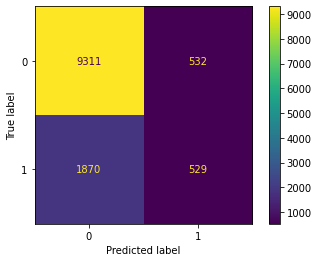

In [22]:
report(y_test, knn_pred)
validation(knn, X, Y, 10)

### 2) Naive Bayesian

In [23]:
gnb = GaussianNB().fit(x_train, y_train)
gnb_pred = gnb.predict(x_test)


True Positive Rate: 0.24 
True Negative Rate: 0.99
Accuracy: 0.39
Mean Squared Error: 0.61
F1 Score: 0.39

10 Fold Validation accuracy: 0.39


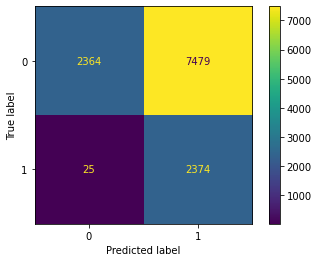

In [24]:
report(y_test, gnb_pred)
validation(gnb, X, Y, 10)

## 3) Decision Tree

In [25]:
dt = DecisionTreeClassifier().fit(x_train, y_train)
dt_pred = dt.predict(x_test)


True Positive Rate: 0.88 
True Negative Rate: 0.32
Accuracy: 0.77
Mean Squared Error: 0.23
F1 Score: 0.35

10 Fold Validation accuracy: 0.77


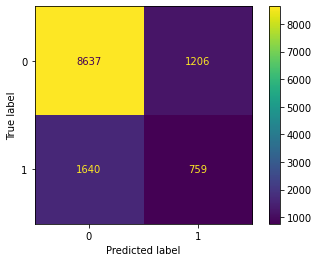

In [26]:
report(y_test, dt_pred)
validation(dt, X, Y, 10)

### 4) Logistic Regression

In [27]:
lr = LogisticRegression().fit(x_train, y_train)
lr_pred = lr.predict(x_test)


True Positive Rate: 1.00 
True Negative Rate: 0.00
Accuracy: 0.80
Mean Squared Error: 0.20
F1 Score: 0.00

10 Fold Validation accuracy: 0.80


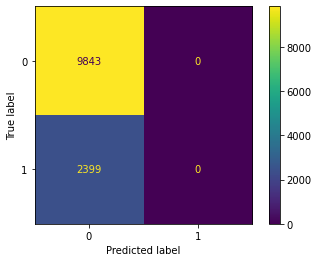

In [28]:
report(y_test, lr_pred)
validation(lr, X, Y, 10)

### 5) Neural Net

In [29]:
model = Sequential()
model.add(keras.layers.Input(shape=(x_train.shape[1],)))
model.add(keras.layers.Dense(units=100, activation='elu'))
model.add(keras.layers.Dense(units=100, activation='elu'))
model.add(keras.layers.Dense(units=1, activation='sigmoid'))
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

In [30]:
history = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
1531/1531 [==============================] - 9s 5ms/step - loss: 0.4506 - accuracy: 0.8006 - val_loss: 0.4429 - val_accuracy: 0.8040
Epoch 2/10
 739/1531 [=============>................] - ETA: 3s - loss: 0.4441 - accuracy: 0.8013

KeyboardInterrupt: 

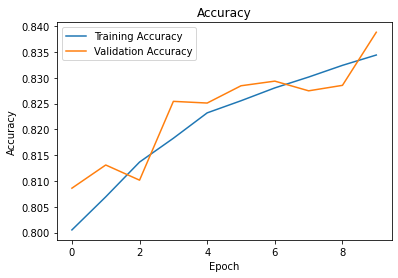

Train accuracy: 0.82

Test accuracy: 0.82
Test loss: 0.40


In [23]:
plot_learning_curve(history)